# Data exploration in SAR Images - Using Numpy arrays

make a distribution analysis by array, combine them all together, and make a distribution with all of them and see what I get

In [4]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../..'))


from offshore_wind_nj.data_loader import data_files, load_data, all_arrays, extract_datetime_from_filename, removed_files
from offshore_wind_nj.sar_wind_plot import plot_wind_field, plot_wind_field_by_arrays
from offshore_wind_nj.data_cleaning import fill_zeros, find_zeros
# load_data(data_files) # Load the files in the module 'data_loader'

2024-10-29 01:29:43.292 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore Wind Research


There are 5773 files


# Data cleaning

In [6]:
list_removed = []
speed_indices = [i for i, arr in enumerate(all_arrays) if find_zeros(arr)]

# Create a list to hold indices of elements to remove
indices_to_remove = []

for i in speed_indices:
    if np.all(all_arrays[i][0] == 0):
        indices_to_remove.append(i)
        removed_files = data_files[i]  # Store the removed file info
        list_removed.append(removed_files)

# Now remove elements in reverse order to avoid index shifting
for i in sorted(indices_to_remove, reverse=True):
    all_arrays.pop(i)
    data_files.pop(i)

# Fill zeros for remaining arrays
for i in speed_indices:
    if i not in indices_to_remove:
        all_arrays[i] = fill_zeros(all_arrays[i])


In [7]:
len(data_files)

5766

# Determine maximum lengths and columns for each array

In [8]:
max_length = max(arr[0].shape[0] for arr in all_arrays)

max_columns_wind_speed = max(arr[0].shape[1] for arr in all_arrays)
max_columns_wind_direction = max(arr[1].shape[1] for arr in all_arrays)
max_columns_latitude = max(arr[2].shape[1] for arr in all_arrays)
max_columns_longitude = max(arr[3].shape[1] for arr in all_arrays)

# Note that the rows & columns are consistent in each image. In other words, wind, direction, lat & lon have the same shape per image

## Pad each array and stack along a new third axis (depth-wise)

In [9]:
padded_data = []

for wind_speed, wind_direction, latitude, longitude in all_arrays:
    padded_wind_speed = np.pad(wind_speed, 
                               ((0, max_length - wind_speed.shape[0]), 
                                (0, max_columns_wind_speed - wind_speed.shape[1])), 
                               mode='constant', constant_values=np.nan)
    
    padded_wind_direction = np.pad(wind_direction, 
                                   ((0, max_length - wind_direction.shape[0]), 
                                    (0, max_columns_wind_direction - wind_direction.shape[1])), 
                                   mode='constant', constant_values=np.nan)
    
    padded_latitude = np.pad(latitude, 
                             ((0, max_length - latitude.shape[0]), 
                              (0, max_columns_latitude - latitude.shape[1])), 
                             mode='constant', constant_values=np.nan)
    
    padded_longitude = np.pad(longitude, 
                              ((0, max_length - longitude.shape[0]), 
                               (0, max_columns_longitude - longitude.shape[1])), 
                              mode='constant', constant_values=np.nan)
    
    # Stack padded arrays along a new third axis
    combined = np.dstack((padded_wind_speed, 
                          padded_wind_direction, 
                          padded_latitude, 
                          padded_longitude))
    
    padded_data.append(combined)

# Example: Access the combined array for the first SAR image
print(padded_data[0].shape)

(241, 286, 4)


- The array 'padded_data' contains the 5774 images. Each image has a shape of (241, 286, 4); there are 241 arrays and each of them has a shape of (286, 4). 

In [10]:
padded_data[0][...,3]

array([[-74.00143 , -73.99057 , -73.97971 , ...,        nan,        nan,
               nan],
       [-74.00357 , -73.99271 , -73.98185 , ...,        nan,        nan,
               nan],
       [-74.00571 , -73.99485 , -73.983986, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

* [..., 0] and [:, :, 0] are similar in that they both select the first element along the last dimension of an array, but they differ in how they specify the preceding dimensions.

In [11]:

valid_data_masks = []  # Will hold valid (non-nan) masks for each image

for wind_speed, wind_direction, latitude, longitude in all_arrays:
    # Create a mask for valid (non-NaN) points
    valid_mask = ~np.isnan(wind_speed) & ~np.isnan(wind_direction)
    
    # Store the valid mask for later
    valid_data_masks.append(valid_mask)

# Let's print the shape of one of the valid masks to confirm it matches the original array
print(valid_data_masks[0].shape)  # Should match original wind_speed shape


(167, 255)


# Analysis Wind Speed

In [12]:
all_wind_speeds = np.concatenate([arr[..., 0].flatten() for arr in padded_data])
filtered_wnd_speed = all_wind_speeds[~np.isnan(all_wind_speeds)]
len(all_wind_speeds)


397427316

## Visualizing the distribuition of the speeds

Mean Wind Speed: 7.44
Median Wind Speed: 6.86
Skewness of Wind Speed Distribution: 0.57
Identified Outliers: [21.04554  19.859734 20.515032 ... 20.       19.8      19.5     ]


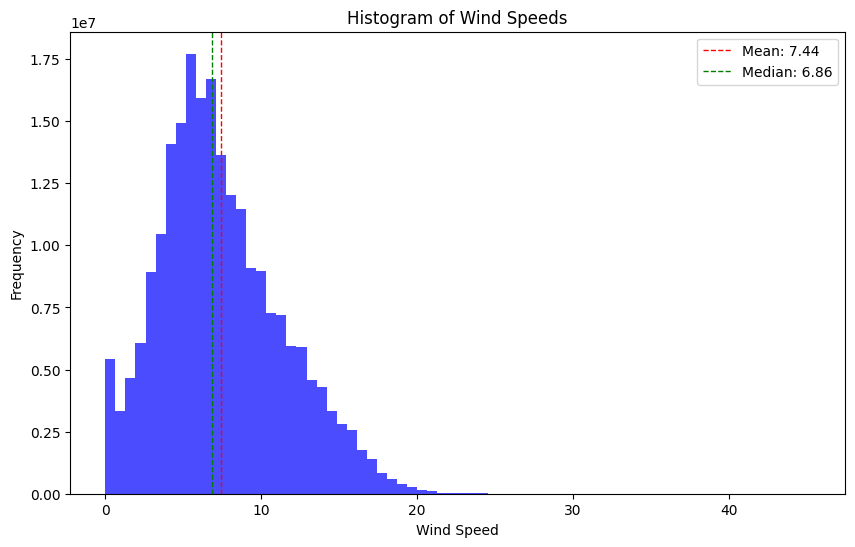

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, zscore

# Assuming all_wind_speeds is your NumPy array with potential np.nan values
mean_speed = np.nanmean(all_wind_speeds)
median_speed = np.nanmedian(all_wind_speeds)
skewness = skew(all_wind_speeds, nan_policy='omit')  # Skew ignores NaNs

# Z-score for identifying outliers, ignoring NaNs
z_scores = zscore(all_wind_speeds, nan_policy='omit')
outliers = all_wind_speeds[np.abs(z_scores) > 3]  # Common threshold for outliers

# Display statistics
print(f"Mean Wind Speed: {mean_speed:.2f}")
print(f"Median Wind Speed: {median_speed:.2f}")
print(f"Skewness of Wind Speed Distribution: {skewness:.2f}")
print(f"Identified Outliers: {outliers}")

plt.figure(figsize=(10, 6))
plt.hist(all_wind_speeds[~np.isnan(all_wind_speeds)], bins=70, color='blue', alpha=0.7)

# Plotting mean and median
plt.axvline(mean_speed, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_speed:.2f}')
plt.axvline(median_speed, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_speed:.2f}')

plt.title('Histogram of Wind Speeds')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Normalizing Speed data
### z-scores

In [13]:
# Calculate mean and std ignoring NaNs
mean_speed = np.nanmean(all_wind_speeds)
std_speed = np.nanstd(all_wind_speeds)

# Z-score normalization
normalized_speeds = (all_wind_speeds - mean_speed) / std_speed


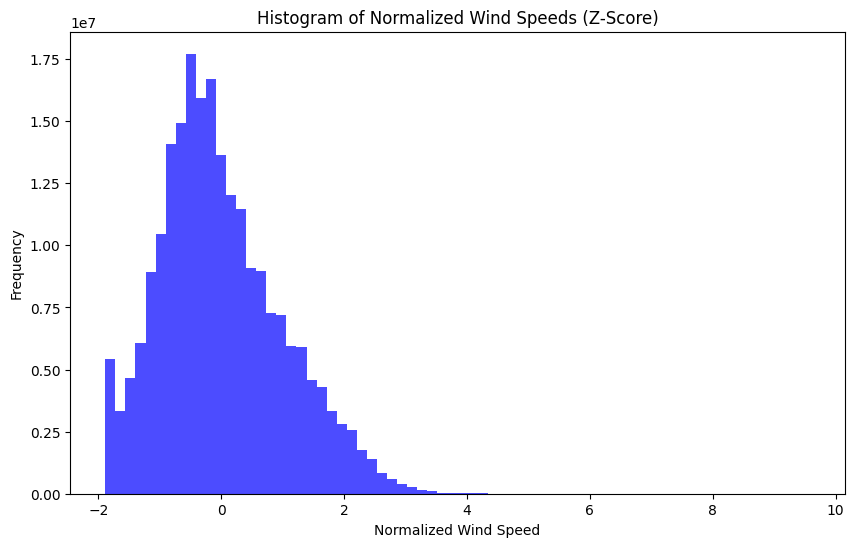

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(normalized_speeds[~np.isnan(normalized_speeds)], bins=70, color='blue', alpha=0.7)
plt.title('Histogram of Normalized Wind Speeds (Z-Score)')
plt.xlabel('Normalized Wind Speed')
plt.ylabel('Frequency')
plt.show()

# Direction

In [15]:
all_wind_directions = np.concatenate([arr[:, :, 1].flatten() for arr in padded_data])


In [16]:
np.max(all_wind_directions[~np.isnan(all_wind_directions)])

360.0

Mean Wind Direction: 200.35
Median Wind Direction: 214.41
Skewness of Wind Direction Distribution: -0.41
Identified Outliers: []


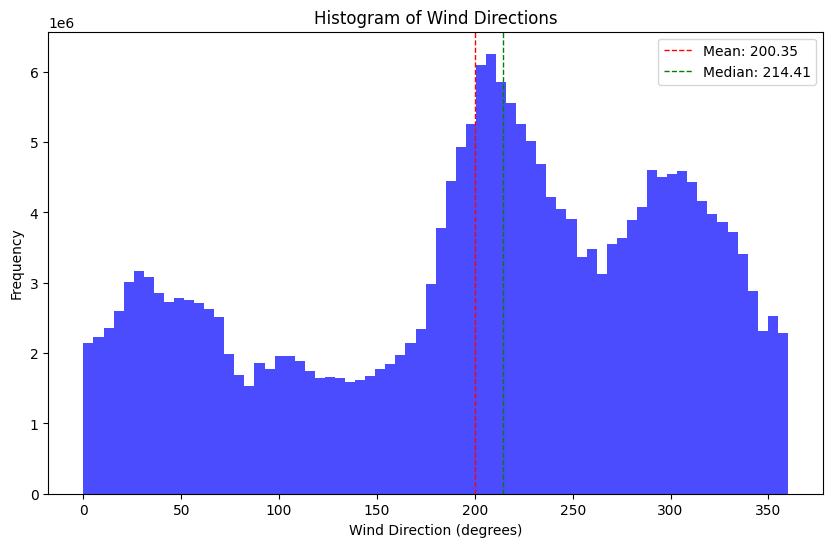

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, zscore

# Assuming all_wind_directions is your NumPy array with potential np.nan values
mean_direction = np.nanmean(all_wind_directions)
median_direction = np.nanmedian(all_wind_directions)
skewness = skew(all_wind_directions, nan_policy='omit')  # Skew ignores NaNs

# Z-score for identifying outliers, ignoring NaNs
z_scores = zscore(all_wind_directions, nan_policy='omit')
outliers = all_wind_directions[np.abs(z_scores) > 3]  # Common threshold for outliers

# Display statistics
print(f"Mean Wind Direction: {mean_direction:.2f}")
print(f"Median Wind Direction: {median_direction:.2f}")
print(f"Skewness of Wind Direction Distribution: {skewness:.2f}")
print(f"Identified Outliers: {outliers}")

# Plotting the histogram of wind directions
plt.figure(figsize=(10, 6))
plt.hist(all_wind_directions[~np.isnan(all_wind_directions)], bins=70, color='blue', alpha=0.7)

# Plotting mean and median
plt.axvline(mean_direction, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_direction:.2f}')
plt.axvline(median_direction, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_direction:.2f}')

plt.title('Histogram of Wind Directions')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


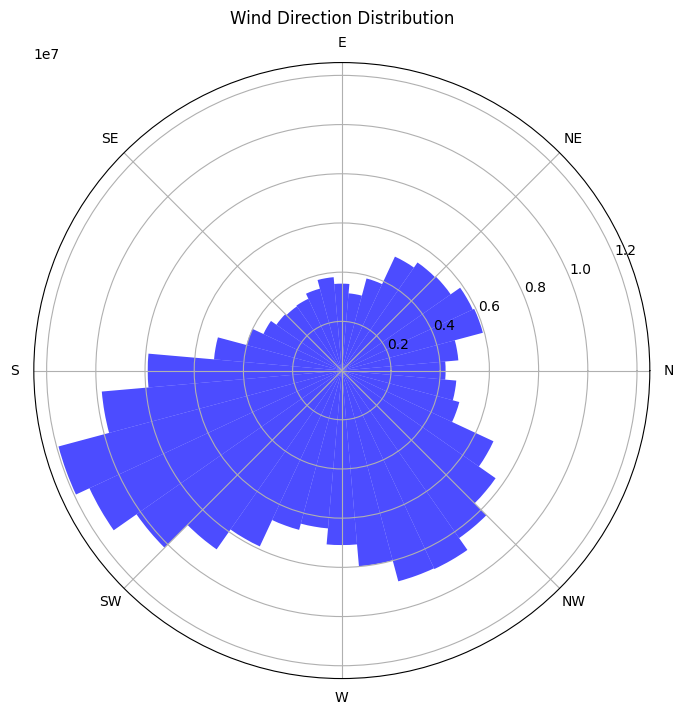

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_wind_directions is your NumPy array with potential np.nan values
# Remove NaNs
valid_directions = all_wind_directions[~np.isnan(all_wind_directions)]

# Number of bins for the wind direction
num_bins = 36  # This gives you 10-degree bins

# Create histogram data
counts, bin_edges = np.histogram(valid_directions, bins=num_bins, range=(0, 360))

# Calculate the angles for the wind rose
angles = np.deg2rad(bin_edges[:-1])  # Convert edges to radians
width = np.deg2rad(360 / num_bins)    # Width of each bin in radians

# Create the plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Create the bars
bars = ax.bar(angles, counts, width=width, bottom=0.0, color='blue', alpha=0.7)

# Add labels and title
ax.set_title('Wind Direction Distribution', va='bottom')
ax.set_xticks(np.deg2rad(np.linspace(0, 360, 8, endpoint=False)))  # Set ticks for N, E, S, W
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])   # Custom labels for ticks

plt.show()


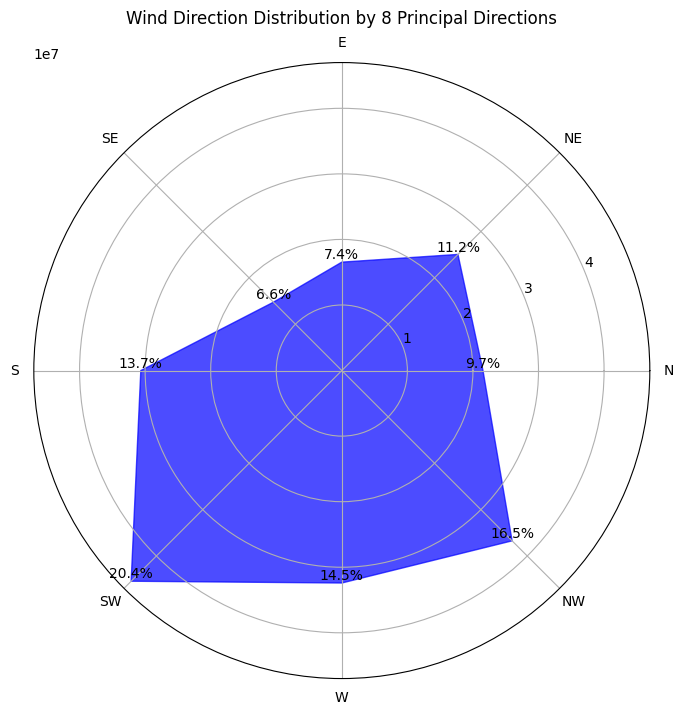

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_wind_directions is your NumPy array with potential np.nan values
# Remove NaNs
valid_directions = all_wind_directions[~np.isnan(all_wind_directions)]

# Count occurrences in each direction
n_count = np.sum((valid_directions >= 0) & (valid_directions < 22.5)) + np.sum((valid_directions >= 337.5) & (valid_directions < 360))  # N
ne_count = np.sum((valid_directions >= 22.5) & (valid_directions < 67.5))  # NE
e_count = np.sum((valid_directions >= 67.5) & (valid_directions < 112.5))  # E
se_count = np.sum((valid_directions >= 112.5) & (valid_directions < 157.5))  # SE
s_count = np.sum((valid_directions >= 157.5) & (valid_directions < 202.5))  # S
sw_count = np.sum((valid_directions >= 202.5) & (valid_directions < 247.5))  # SW
w_count = np.sum((valid_directions >= 247.5) & (valid_directions < 292.5))  # W
nw_count = np.sum((valid_directions >= 292.5) & (valid_directions < 337.5))  # NW

# Create a list of counts and labels
counts = np.array([n_count, ne_count, e_count, se_count, s_count, sw_count, w_count, nw_count])
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

# Calculate percentages
percentages = (counts / np.sum(counts)) * 100

# Create the plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Define the angles for the directions
angles = np.deg2rad(np.linspace(0, 360, len(counts), endpoint=False))  # Angles for N, NE, E, SE, S, SW, W, NW
counts = np.append(counts, counts[0])  # Close the loop for plotting
angles = np.append(angles, angles[0])  # Close the loop for angles

# Create the bars
ax.fill(angles, counts, color='blue', alpha=0.7)

# Add percentage labels to the bars
for angle, percent in zip(angles[:-1], percentages):
    ax.text(angle, counts[np.where(angles == angle)[0][0]], f'{percent:.1f}%', ha='center', va='bottom')

# Add labels and title
ax.set_title('Wind Direction Distribution by 8 Principal Directions', va='bottom')
ax.set_xticks(angles[:-1])  # Set ticks for N, NE, E, SE, S, SW, W, NW
ax.set_xticklabels(labels)  # Custom labels for directions

plt.show()


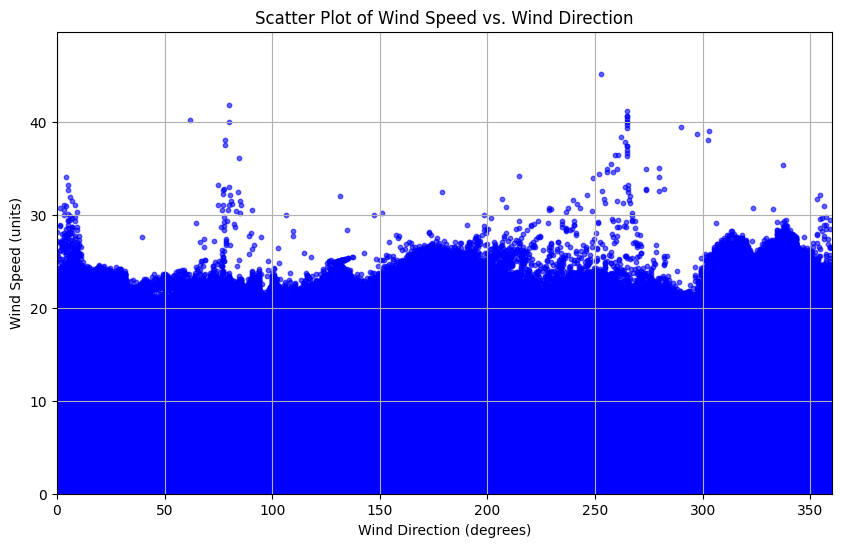

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have two NumPy arrays: all_wind_speeds and all_wind_directions
# Remove NaNs
valid_speeds = all_wind_speeds[~np.isnan(all_wind_speeds) & ~np.isnan(all_wind_directions)]
valid_directions = all_wind_directions[~np.isnan(all_wind_speeds) & ~np.isnan(all_wind_directions)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(valid_directions, valid_speeds, alpha=0.6, color='blue', s=10)

# Add labels and title
plt.title('Scatter Plot of Wind Speed vs. Wind Direction')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Wind Speed (units)')  # Replace 'units' with the actual units of wind speed (e.g., m/s, km/h)
plt.xlim(0, 360)  # Set x-axis limits to cover all directions
plt.ylim(0, np.max(valid_speeds) * 1.1)  # Set y-axis limits based on maximum wind speed
plt.grid(True)

# Show the plot
plt.show()


Pearson Correlation: 0.125, p-value: 0.000
Circular Correlation: 0.050


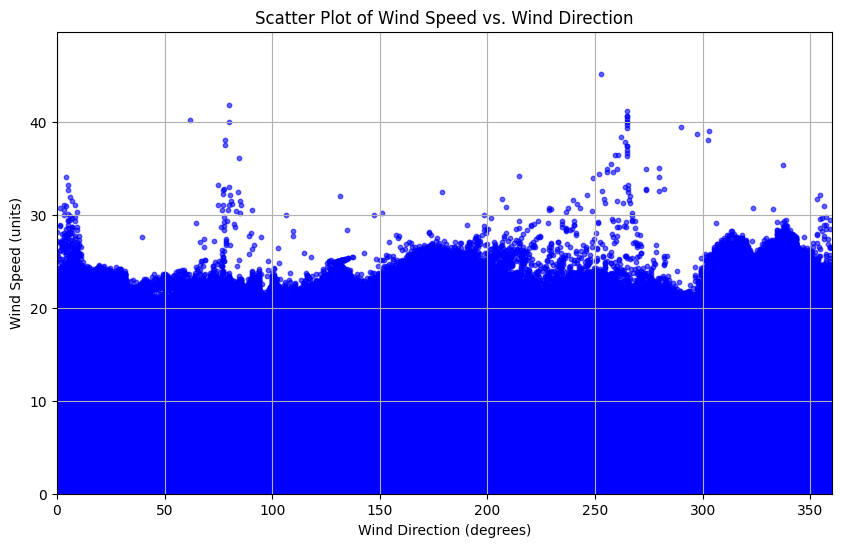

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import circmean

# Assuming you have valid_speeds and valid_directions from previous data preparation

# Step 1: Calculate Pearson correlation
pearson_corr, p_value = pearsonr(valid_directions, valid_speeds)

# Step 2: Calculate Circular Correlation
def circular_correlation(x, y):
    # Convert degrees to radians
    x_rad = np.deg2rad(x)
    y_rad = np.deg2rad(y)
    
    # Calculate mean resultant vector length
    r = np.sqrt(np.sum(np.cos(x_rad) * np.cos(y_rad))**2 + np.sum(np.sin(x_rad) * np.sin(y_rad))**2)
    n = len(x)
    
    return r / n  # Return the correlation coefficient

circ_corr = circular_correlation(valid_directions, valid_speeds)

# Print the results
print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {p_value:.3f}")
print(f"Circular Correlation: {circ_corr:.3f}")

# Step 3: Visualize the scatter plot again
plt.figure(figsize=(10, 6))
plt.scatter(valid_directions, valid_speeds, alpha=0.6, color='blue', s=10)
plt.title('Scatter Plot of Wind Speed vs. Wind Direction')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Wind Speed (units)')
plt.xlim(0, 360)
plt.ylim(0, np.max(valid_speeds) * 1.1)
plt.grid(True)
plt.show()


/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


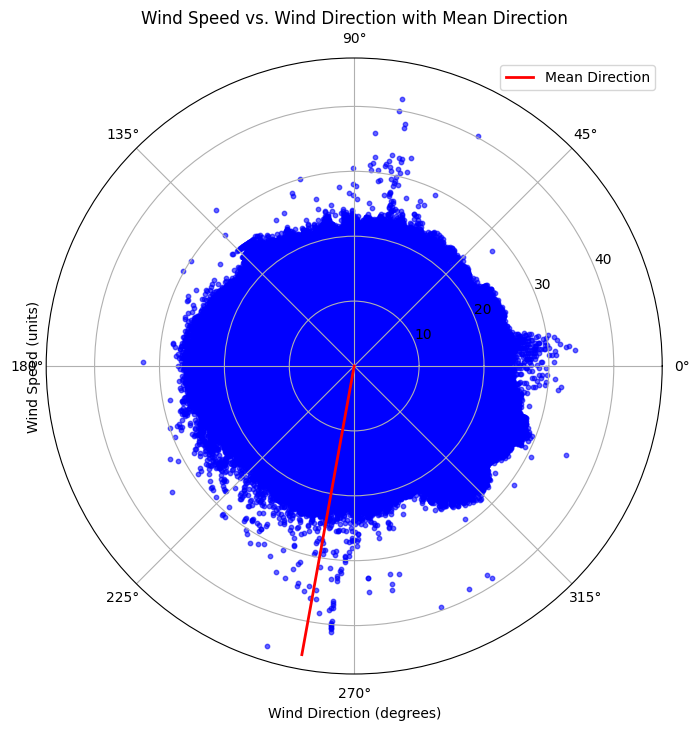

In [21]:
from scipy.stats import circmean

# Calculate circular mean of wind directions
mean_direction = circmean(valid_directions, high=360, low=0)

# Optionally, visualize the mean direction
plt.figure(figsize=(8, 8))
plt.polar([0, np.deg2rad(mean_direction)], [0, max(valid_speeds)], color='red', linewidth=2, label='Mean Direction')
plt.scatter(np.deg2rad(valid_directions), valid_speeds, alpha=0.6, color='blue', s=10)
plt.title('Wind Speed vs. Wind Direction with Mean Direction')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Wind Speed (units)')
plt.legend()
plt.show()


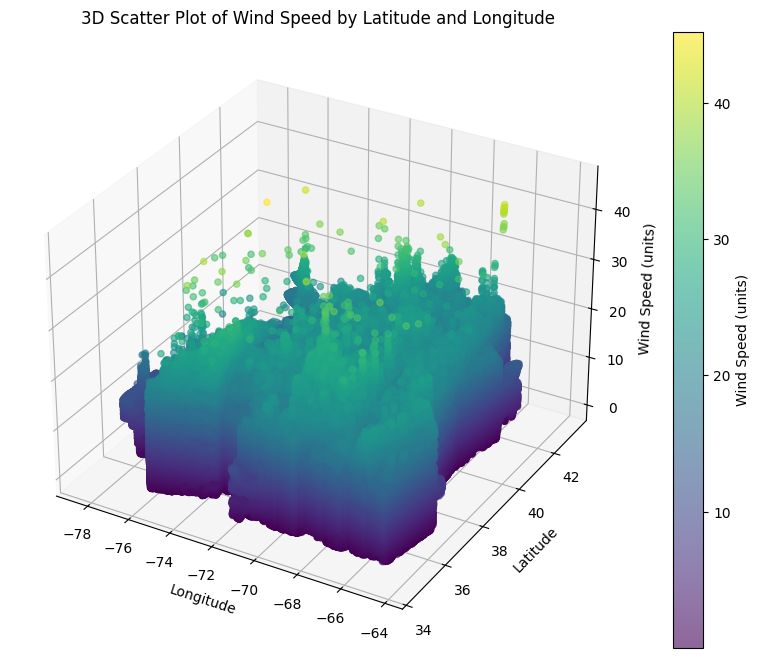

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming valid_latitudes, valid_longitudes, and valid_speeds are your data arrays
all_latitudes = np.concatenate([arr[:, :, 2].flatten() for arr in padded_data])
valid_latitudes = all_latitudes[~np.isnan(all_wind_speeds)]

all_longitudes = np.concatenate([arr[:, :, 3].flatten() for arr in padded_data])
valid_longitudes = all_longitudes[~np.isnan(all_wind_speeds)]

# 3D Scatter Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(valid_longitudes, valid_latitudes, valid_speeds, c=valid_speeds, cmap='viridis', alpha=0.6)

# Labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Wind Speed (units)')
plt.title('3D Scatter Plot of Wind Speed by Latitude and Longitude')

# Color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Wind Speed (units)')

plt.show()


# Apply the clustering... (still in review)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [38]:


# Step 1: Extract valid data points based on the valid mask
valid_data_points = []

for idx, (wind_speed, wind_direction, latitude, longitude) in enumerate(all_arrays):
    # Get the valid mask for this image
    valid_mask = valid_data_masks[idx]
    
    # Extract only valid (non-nan) data points for each feature
    valid_wind_speed = wind_speed[valid_mask]
    valid_wind_direction = wind_direction[valid_mask]
    valid_latitude = latitude[valid_mask]
    valid_longitude = longitude[valid_mask]
    
    # Combine the valid data points into a single array (rows: valid pixels, columns: features)
    valid_combined = np.column_stack((valid_wind_speed, valid_wind_direction, valid_latitude, valid_longitude))
    
    valid_data_points.append(valid_combined)

# Step 2: Stack all valid data points across images into one large dataset
all_valid_data = np.vstack(valid_data_points)

# Step 3: Normalize the data
scaler = StandardScaler()
all_valid_data_scaled = scaler.fit_transform(all_valid_data)

# Step 4: Apply K-Means Clustering
n_clusters = 4  # Adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_valid_data_scaled)

# Step 5: Get cluster labels
cluster_labels = kmeans.labels_

# Step 6: Now, we need to assign the cluster labels back to the valid points in the original images
reshaped_labels = []
start_idx = 0

for idx, valid_mask in enumerate(valid_data_masks):
    num_valid_points = np.sum(valid_mask)  # Number of valid data points in this image
    
    # Extract the cluster labels corresponding to the valid points for this image
    labels = cluster_labels[start_idx:start_idx + num_valid_points]
    
    # Create an empty array to store the labels, with the same shape as the padded arrays
    label_array = np.full(valid_mask.shape, np.nan)  # Fill with np.nan for invalid points
    
    # Fill valid points with cluster labels
    label_array[valid_mask] = labels
    
    reshaped_labels.append(label_array)  # Add to the list of reshaped labels
    
    # Move to the next set of labels in the cluster_labels array
    start_idx += num_valid_points

# The reshaped_labels list now contains the cluster labels for each image, with np.nan in padded areas


# Clustering by speed / direction (not together)

/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


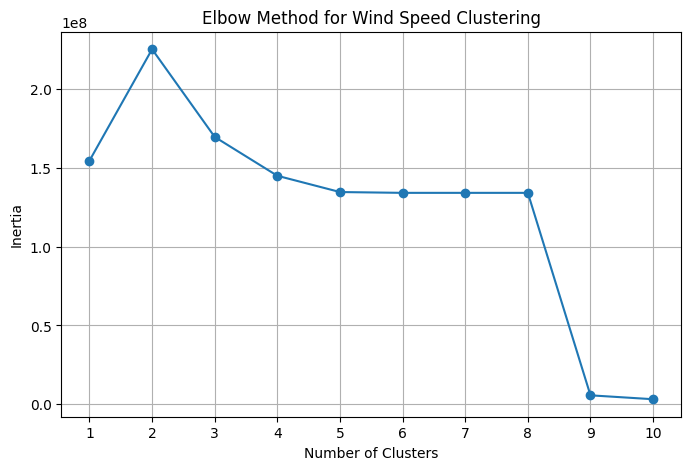

/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


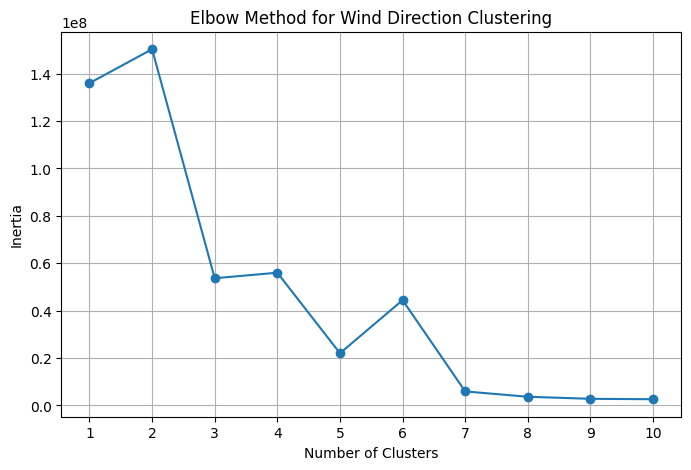

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 1: Extract valid data points based on the valid mask
valid_data_points = []

for idx, (wind_speed, wind_direction, latitude, longitude) in enumerate(all_arrays):
    valid_mask = valid_data_masks[idx]
    
    # Extract only valid (non-nan) data points for each feature
    valid_wind_speed = wind_speed[valid_mask]
    valid_wind_direction = wind_direction[valid_mask]
    
    # Combine the valid data points into a single array (rows: valid pixels, columns: features)
    valid_combined = np.column_stack((valid_wind_speed, valid_wind_direction))
    valid_data_points.append(valid_combined)

# Step 2: Stack all valid data points across images into one large dataset
all_valid_data = np.vstack(valid_data_points)

# Step 3: Normalize the data for speed and direction separately
scaler_speed = StandardScaler()
scaler_direction = StandardScaler()

# Normalizing speed
all_valid_speed_scaled = scaler_speed.fit_transform(all_valid_data[:, 0].reshape(-1, 1))

# Normalizing direction
all_valid_direction_scaled = scaler_direction.fit_transform(all_valid_data[:, 1].reshape(-1, 1))

# Function to compute the elbow method
def plot_elbow(data, max_clusters=10, title='Elbow Method'):
    inertia = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid()
    plt.show()

# Step 4: Plot elbow method for wind speed
plot_elbow(all_valid_speed_scaled, title='Elbow Method for Wind Speed Clustering')

# Step 5: Plot elbow method for wind direction
plot_elbow(all_valid_direction_scaled, title='Elbow Method for Wind Direction Clustering')

# Step 6: Apply K-Means Clustering for speed and direction
n_clusters = 3  # Default number of clusters
kmeans_speed = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_direction = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the models
kmeans_speed.fit(all_valid_speed_scaled)
kmeans_direction.fit(all_valid_direction_scaled)

# Step 7: Get cluster labels
speed_cluster_labels = kmeans_speed.labels_
direction_cluster_labels = kmeans_direction.labels_

# Step 8: Assign the cluster labels back to the valid points in the original images
# You can follow similar steps as in your original code to reshape and assign labels
reshaped_speed_labels = []
reshaped_direction_labels = []
start_idx_speed = 0
start_idx_direction = 0

for idx, valid_mask in enumerate(valid_data_masks):
    num_valid_points = np.sum(valid_mask)  # Number of valid data points in this image
    
    # Extract the cluster labels corresponding to the valid points for speed
    speed_labels = speed_cluster_labels[start_idx_speed:start_idx_speed + num_valid_points]
    
    # Create an empty array for speed labels
    speed_label_array = np.full(valid_mask.shape, np.nan)  # Fill with np.nan for invalid points
    speed_label_array[valid_mask] = speed_labels
    reshaped_speed_labels.append(speed_label_array)  # Add to the list of reshaped labels for speed
    
    # Extract the cluster labels corresponding to the valid points for direction
    direction_labels = direction_cluster_labels[start_idx_direction:start_idx_direction + num_valid_points]
    
    # Create an empty array for direction labels
    direction_label_array = np.full(valid_mask.shape, np.nan)
    direction_label_array[valid_mask] = direction_labels
    reshaped_direction_labels.append(direction_label_array)  # Add to the list of reshaped labels for direction
    
    # Move to the next set of labels in the cluster_labels array
    start_idx_speed += num_valid_points
    start_idx_direction += num_valid_points


In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

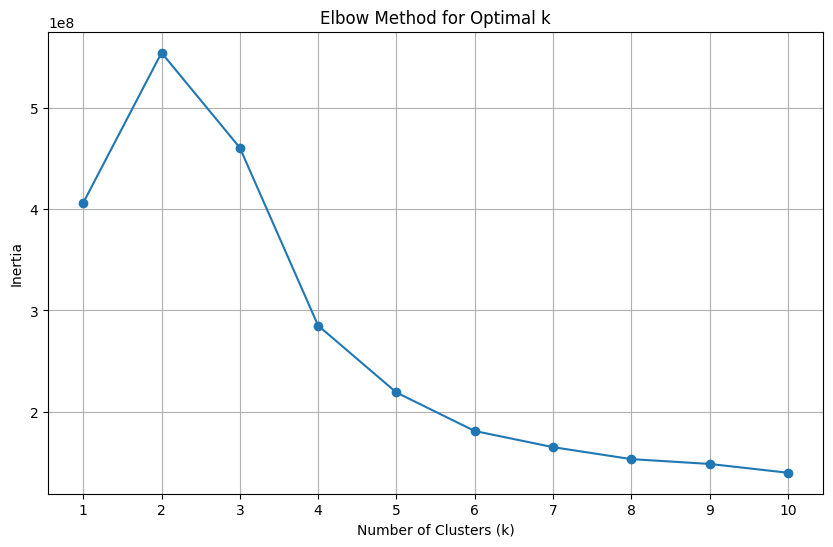

In [36]:


# Step 1: Fit K-Means for a range of k values
inertia_values = []
k_range = range(1, 11)  # You can adjust this range as needed

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_valid_data_scaled)  # Use your normalized data
    inertia_values.append(kmeans.inertia_)

# Step 2: Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()
plt.show()


In [39]:
import matplotlib.pyplot as plt

# Assuming you want to visualize wind speed and wind direction
plt.figure(figsize=(10, 6))
plt.scatter(all_valid_data_scaled[:, 0], all_valid_data_scaled[:, 1], 
            c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering of Wind Data')
plt.xlabel('Normalized Wind Speed')
plt.ylabel('Normalized Wind Direction')
plt.colorbar(label='Cluster Label')
plt.show()


KeyboardInterrupt: 

In [35]:
from collections import defaultdict

# Initialize a dictionary to hold clusters and their corresponding images
clusters_dict = defaultdict(list)

# Iterate over the reshaped labels and original arrays
for idx, label_array in enumerate(reshaped_labels):
    # Get the unique labels in this image
    unique_labels = np.unique(label_array)
    
    for label in unique_labels:
        if not np.isnan(label):  # Only consider valid labels
            clusters_dict[label].append(idx)  # Append the index of the image to the cluster

# Now clusters_dict contains cluster labels as keys and lists of image indices as values
for cluster_label, image_indices in clusters_dict.items():
    print(f'Cluster {cluster_label}: Images {image_indices}')


Cluster 1.0: Images [0, 1, 2, 3, 4, 5, 7, 9, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 47, 48, 50, 51, 52, 53, 54, 55, 58, 60, 64, 69, 73, 77, 78, 80, 86, 90, 95, 96, 100, 103, 106, 107, 108, 109, 112, 114, 116, 117, 118, 120, 122, 123, 125, 126, 129, 130, 132, 134, 135, 136, 137, 138, 139, 142, 144, 145, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 164, 165, 166, 167, 168, 171, 172, 173, 176, 177, 179, 181, 182, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 214, 215, 216, 217, 218, 219, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 260, 261, 262, 263, 265, 266, 267, 268, 269, 270, 272, 273, 274, 275, 277, 278, 279, 280, 281, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 297, 298, 29

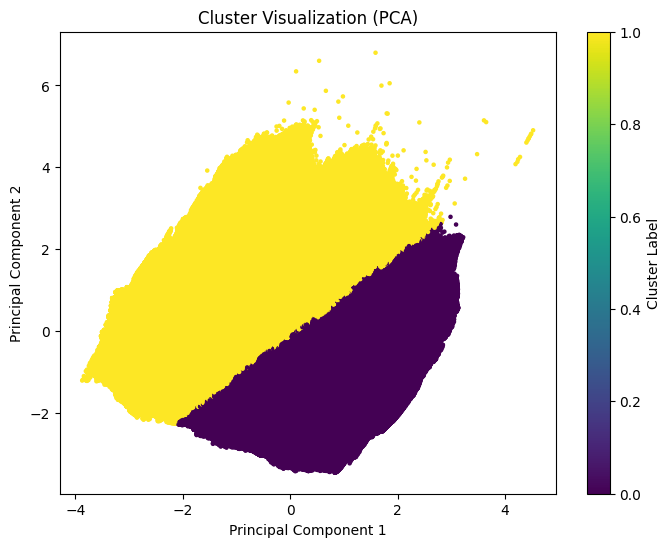

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(all_valid_data_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='viridis', s=5)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Flatten each combined 3D array into a 2D array
# Shape before flattening: (max_length, max_columns, 4)
# Shape after flattening: (max_length * max_columns, 4)

flattened_data = []
for combined_array in padded_data:
    # Flatten to shape (max_length * max_columns, 4)
    flattened_array = combined_array.reshape(-1, 4)  # Flatten spatial dimensions, keep feature layers
    flattened_data.append(flattened_array)

# Step 2: Stack all flattened arrays into one dataset
# Concatenate to shape (n_samples, 4), where n_samples = sum of all image sizes
all_data = np.vstack(flattened_data)

# Step 3: Remove rows with np.nan (in case some areas were padded)
all_data_clean = all_data[~np.isnan(all_data).any(axis=1)]

# Step 4: Normalize the data to ensure each feature is on the same scale
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data_clean)

# Step 5: Apply K-Means Clustering (you can try other algorithms too)
n_clusters = 5  # Set number of clusters (can be adjusted)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_data_scaled)

# Step 6: Get the cluster labels
cluster_labels = kmeans.labels_

# Step 7: Reshape the cluster labels back into the original spatial structure (for visualization)
reshaped_labels = []
start_idx = 0

for combined_array in padded_data:
    original_shape = combined_array.shape[:2]  # (max_length, max_columns)
    num_pixels = original_shape[0] * original_shape[1]
    
    # Extract the corresponding labels for this image and reshape
    labels = cluster_labels[start_idx:start_idx + num_pixels]
    reshaped_labels.append(labels.reshape(original_shape))
    
    start_idx += num_pixels

# Now, reshaped_labels contains the clustering result for each SAR image
print(reshaped_labels[0].shape)  # Shape of the clustering result for the first image


NameError: name 'padded_data' is not defined

In [ ]:
for idx, (wind_speed, wind_direction, latitude, longitude) in enumerate(all_arrays):
    # Get the valid mask for this image
    valid_mask = valid_data_masks[idx]
    
    # Extract only valid (non-nan) data points for each feature
    valid_wind_speed = wind_speed[valid_mask]
    valid_wind_direction = wind_direction[valid_mask]
    valid_latitude = latitude[valid_mask]
    valid_longitude = longitude[valid_mask]
    
    # Combine the valid data points into a single array (rows: valid pixels, columns: features)
    valid_combined = np.column_stack((valid_wind_speed, valid_wind_direction, valid_latitude, valid_longitude))
    
    valid_data_points.append(valid_combined)

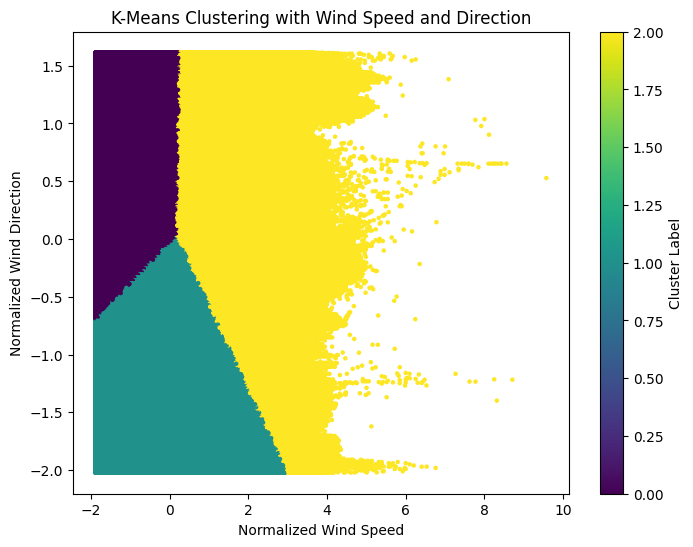

In [10]:
# Step 1: Extract wind speed and direction from all_arrays
speed_direction_data = []
for idx,(wind_speed, wind_direction, _, _) in enumerate(all_arrays):
    valid_mask = valid_data_masks[idx]  # Assuming valid masks are still applicable
    valid_wind_speed = wind_speed[valid_mask]
    valid_wind_direction = wind_direction[valid_mask]
    valid_combined = np.column_stack((valid_wind_speed, valid_wind_direction))
    speed_direction_data.append(valid_combined)

# Step 2: Stack all valid speed and direction data
all_speed_direction = np.vstack(speed_direction_data)

# Step 3: Normalize the data
scaler = StandardScaler()
all_speed_direction_scaled = scaler.fit_transform(all_speed_direction)

# Step 4: Apply K-Means Clustering
n_clusters = 3  # You can adjust based on your analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_speed_direction_scaled)

# Get cluster labels
cluster_labels = kmeans.labels_

# Step 5: Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(all_speed_direction_scaled[:, 0], all_speed_direction_scaled[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.title('K-Means Clustering with Wind Speed and Direction')
plt.xlabel('Normalized Wind Speed')
plt.ylabel('Normalized Wind Direction')
plt.colorbar(label='Cluster Label')
plt.show()


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Initialize variables
inertia = []
range_n_clusters = range(1, 11)  # You can adjust the upper limit as needed

# Step 2: Calculate inertia for different cluster counts
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_speed_direction_scaled)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()


286

In [99]:
max_columns_wind_direction

286

In [100]:
max_columns_wind_speed

286

# using DBSCAN

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture  # Corrected import
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Step 1: Extract valid data points from padded_data
valid_data_points = []

for arr in padded_data:
    wind_speed = arr[:, :, 0]  # Adjust index based on your actual data structure
    wind_direction = arr[:, :, 1]  # Adjust index for direction
    latitude = arr[:, :, 2]  # Adjust index for latitude
    longitude = arr[:, :, 3]  # Adjust index for longitude

    # Assuming a mask to filter valid data points (e.g., not NaN)
    valid_mask = ~np.isnan(wind_speed) & ~np.isnan(wind_direction) & ~np.isnan(latitude) & ~np.isnan(longitude)

    # Extract valid data points
    valid_combined = np.column_stack((wind_speed[valid_mask], wind_direction[valid_mask],
                                       latitude[valid_mask], longitude[valid_mask]))
    valid_data_points.append(valid_combined)

# Stack all valid data points into a single array
all_valid_data = np.vstack(valid_data_points)


In [17]:
all_valid_data

array([[  9.112082, 191.50705 ,  35.73571 , -74.00143 ],
       [  8.611857, 191.51346 ,  35.737404, -73.99057 ],
       [  8.684312, 191.51987 ,  35.739094, -73.97971 ],
       ...,
       [ 16.1     , 323.26788 ,  38.557686, -70.89739 ],
       [ 16.4     , 322.2609  ,  38.55911 , -70.90872 ],
       [ 17.7     , 320.2539  ,  38.56053 , -70.92005 ]], dtype=float32)

## Normilize the data

In [15]:
# Normalize the data
scaler = StandardScaler()
all_valid_data_scaled = scaler.fit_transform(all_valid_data)


## Step 3: Apply DBSCAN

In [ ]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your data
dbscan_labels = dbscan.fit_predict(all_valid_data_scaled)

# Plotting DBSCAN Results
plt.figure(figsize=(10, 6))
plt.scatter(all_valid_data[:, 3], all_valid_data[:, 2], c=dbscan_labels, cmap='viridis', s=5)  # Lon, Lat
plt.title('DBSCAN Clustering of Wind Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()


# apply gaussian

In [ ]:
# Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=3, random_state=42)  # Adjust n_components based on your analysis
gmm_labels = gmm.fit_predict(all_valid_data_scaled)

# Plotting GMM Results
plt.figure(figsize=(10, 6))
plt.scatter(all_valid_data[:, 3], all_valid_data[:, 2], c=gmm_labels, cmap='viridis', s=5)  # Lon, Lat
plt.title('GMM Clustering of Wind Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()


# Hierarchical Clustering 

In [ ]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3)  # Adjust n_clusters based on your analysis
hierarchical_labels = hierarchical.fit_predict(all_valid_data_scaled)

# Plotting Hierarchical Clustering Results
plt.figure(figsize=(10, 6))
plt.scatter(all_valid_data[:, 3], all_valid_data[:, 2], c=hierarchical_labels, cmap='viridis', s=5)  # Lon, Lat
plt.title('Hierarchical Clustering of Wind Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()
